# Audio File EDA, Image Creation, Pre-processing, FSM

- Converting the the audio files to square Mel-spectrograms, and saving in spectrograms/(BigRoom, DrumAndBass, Techno)
- Applying pre-processing
- FSM CNN with TensorFlow

In [33]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Blues", as_cmap=True)

# Standard Packages
import numpy as np
import warnings
import pandas as pd
import os
import shutil
import random
import time
import PIL
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, \
                                    Dense, concatenate, Dropout, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#for loading and visualizing audio files
import librosa
import librosa.display
from scipy import signal
from scipy.io import wavfile
import wave
# import specAugment
# from spec_augment import SpecAugment
# from specAugment import spec_augment_tensorflow

#to play audio
import IPython.display as ipd

### Getting list of genre_names and setting the audio_fpath variable

In [2]:
audio_fpath = "../data/subgenre_dataset/"
genre_names = os.listdir(audio_fpath)
print(genre_names)

['Breaks', 'BigRoom', 'PsyTrance', 'TechHouse', 'ReggaeDub', 'ElectronicaDowntempo', '.DS_Store', 'IndieDanceNuDisco', 'HardcoreHardTechno', 'Trance', 'Minimal', 'ElectroHouse', 'Dance', 'DrumAndBass', 'HipHop', 'GlitchHop', 'House', 'HardDance', 'ProgressiveHouse', 'FutureHouse', 'FunkRAndB', 'Dubstep', 'DeepHouse', 'Techno']


### Getting list of file paths for the 3 selected genres

In [3]:
big_room_file_paths = [audio_fpath + 'BigRoom/' + f for f in os.listdir(audio_fpath + 'BigRoom/') if '.wav' in f]
# big_room_file_paths

In [4]:
dnb_file_paths = [audio_fpath + 'DrumAndBass/' + f for f in os.listdir(audio_fpath + 'DrumAndBass/') if '.wav' in f]
# dnb_file_paths

In [5]:
techno_file_paths = [audio_fpath + 'Techno/' + f for f in os.listdir(audio_fpath + 'Techno/') if '.wav' in f]
# techno_file_paths

## Image pre-processing

### Data has already been train, validate, test split

#### We use Generators because we want to be able to expand this to larger datasets
This means we need to use fit_generator and predict_generator functions during training and testing

In [6]:
# Batch size should be exponential of 2 but smaller than val size. Image width and height already loads in as 256x256

batch_size = 16
# img_height = 256
# img_width = 256
img_height = 512
img_width = 512
num_channels = 1  # It is grayscale. RGB would be 3


# Set the root directory containing the subdirectories for each class
root_dir = '../spectrograms/high_res/halves/'

# Create the train, validation, and test directories
train_dir = root_dir + 'train/'
val_dir = root_dir + 'validate/'
test_dir = root_dir + 'test/'

In [7]:
from PIL import Image
  
# get image
filepath = train_dir + 'BigRoom/' + 'BigRoom001_half2.png'
img = Image.open(filepath)
  
# get width and height
width = img.width
height = img.height
  
# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)

The height of the image is:  6840
The width of the image is:  6840


In [8]:
np.max(np.asarray(img)) - np.asarray(img)

array([[[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [ 15,  15,  15,   0],
        [ 13,  13,  13,   0],
        [ 10,  10,  10,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [ 15,  15,  15,   0],
        [ 13,  13,  13,   0],
        [ 10,  10,  10,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [ 15,  15,  15,   0],
        [ 13,  13,  13,   0],
        [ 10,  10,  10,   0]],

       ...,

       [[ 96,  96,  96,   0],
        [ 97,  97,  97,   0],
        [ 97,  97,  97,   0],
        ...,
        [158, 158, 158,   0],
        [158, 158, 158,   0],
        [158, 158, 158,   0]],

       [[ 96,  96,  96,   0],
        [ 97,  97,  97,   0],
        [ 97,  97,  97,   0],
        ...,
        [158, 158, 158,   0],
        [158, 158, 158,   0],
        [158, 158, 158,   0]],

       [[ 96

In [9]:
np.asarray(img)

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [240, 240, 240, 255],
        [242, 242, 242, 255],
        [245, 245, 245, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [240, 240, 240, 255],
        [242, 242, 242, 255],
        [245, 245, 245, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [240, 240, 240, 255],
        [242, 242, 242, 255],
        [245, 245, 245, 255]],

       ...,

       [[159, 159, 159, 255],
        [158, 158, 158, 255],
        [158, 158, 158, 255],
        ...,
        [ 97,  97,  97, 255],
        [ 97,  97,  97, 255],
        [ 97,  97,  97, 255]],

       [[159, 159, 159, 255],
        [158, 158, 158, 255],
        [158, 158, 158, 255],
        ...,
        [ 97,  97,  97, 255],
        [ 97,  97,  97, 255],
        [ 97,  97,  97, 255]],

       [[159

#### Preprocessing functions for ImageDataGenerator

In [12]:
'''
freq_mask:
    spec: Input spectrogram (2D numpy array).
    F: The maximum width of each frequency mask.
    num_masks: The number of frequency masks to apply.
    replace_with_zero: Whether to replace the masked frequencies with zeros or with the mean value of the spectrogram.

time_mask:
    spec: Input spectrogram (2D numpy array).
    T: The maximum width of each time mask.
    num_masks: The number of time masks to apply.
    replace_with_zero: Whether to replace the masked time steps with zeros or with the mean value of the spectrogram.
'''


def freq_mask(spec, F=75, num_masks=1, replace_with_zero=True):
    cloned = np.copy(spec)
    num_mel_channels = cloned.shape[1]
    
    for i in range(0, num_masks):       
        f = random.randrange(25, F)                     # min to max width of the mask
        f_zero = random.randrange(0, num_mel_channels - f)
        
        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): 
            return cloned
        
        mask_end = random.randrange(f_zero, f_zero + f) 
        if (replace_with_zero):
            cloned[:, f_zero:mask_end] = 0
        else:
            cloned[:, f_zero:mask_end] = cloned.mean()
    
    return cloned


def time_mask(spec, T=75, num_masks=1, replace_with_zero=True):
    cloned = np.copy(spec)
    len_spectro = cloned.shape[0]
    
    for i in range(0, num_masks):
        t = random.randrange(25, T)                      # min to max width of the mask
        t_zero = random.randrange(0, len_spectro - t)
        
        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t):
            return cloned
        
        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
            cloned[t_zero:mask_end, :] = 0
        else:
            cloned[t_zero:mask_end, :] = cloned.mean()
    return cloned


def flip_intensity(spec):
    # Flip the intensity values of the image (black to white and flip values inbetween)
    spec = np.max(spec) - spec
    return spec


def sc(spec: np.ndarray):
    spec = flip_intensity(spec)
#     spec = freq_mask(spec)
    spec = time_mask(spec)
    return spec


#### With rescaling. Only masking time and frequency of training set. Applying intensity flip to all.

In [14]:
# Create data generators for the train, validation, and test sets

# Need to look into the rescale value. This is the scaling used for color images. Should it be different for grayscale?

train_data_gen = ImageDataGenerator(preprocessing_function=sc, rescale=1./255).flow_from_directory(
        directory=train_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        seed=123
)

validation_data_gen = ImageDataGenerator(preprocessing_function=flip_intensity, rescale=1./255).flow_from_directory(
        directory=val_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        seed=123
)

test_data_gen = ImageDataGenerator(preprocessing_function=flip_intensity, rescale=1./255).flow_from_directory(
        directory=test_dir,
        target_size=(img_height, img_width),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        seed=123
)

Found 420 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


(16, 256, 256, 1)


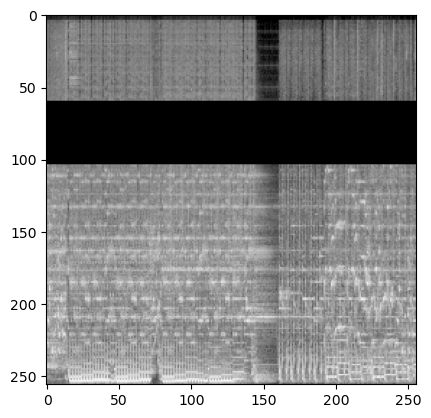

(16, 256, 256, 1)


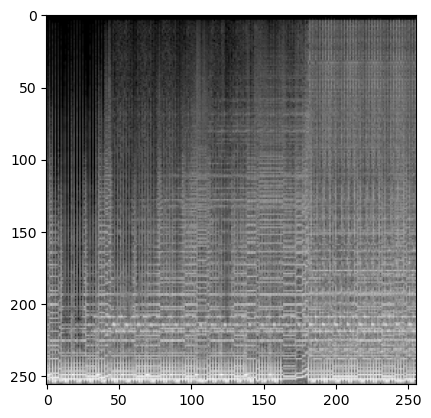

In [15]:
for _ in range(2):
    img, label = train_data_gen.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0], cmap='gray')
    plt.show()

(16, 256, 256, 1)


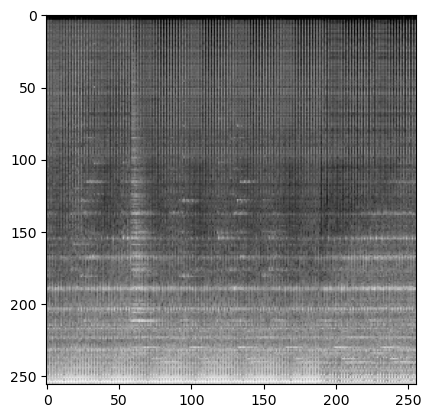

(16, 256, 256, 1)


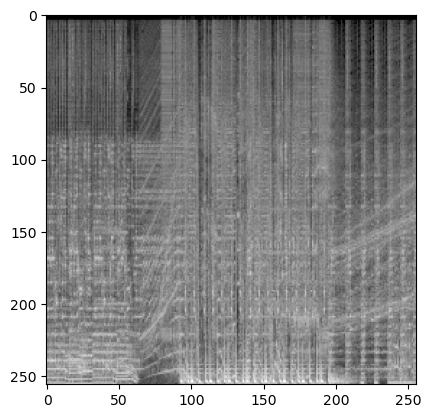

In [16]:
for _ in range(2):
    img, label = validation_data_gen.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0], cmap='gray')
    plt.show()

## FIRST FSM

In [18]:
lr = 0.5e-3
stride = 2
padding = 'same'     # Temporary padding selection - STILL NEED TO IMPLEMENT
kernel_size = (3, 3)
input_shape=(img_height, img_width, num_channels)

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
history.history.keys()

### SAVE AND LOAD MODEL

In [ ]:
model2.save('../models/' + model_file_name)

In [ ]:
# Loading in the saved model
saved_model = load_model('../models/' + model_file_name)

# Alternate Model

# Trying a model from

https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab


In [ ]:
model2 = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), 
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
                    Dropout(0.25),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(3, activation='softmax')])

In [ ]:
model2.compile(# optimizer='adam',
               optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
start_time = time.time()
history = model2.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=100,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
        callbacks=[early_stop]
)
print(time.time() - start_time)

In [ ]:
# Get the predictions for the test set
test_predictions_percentages2 = model2.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions2 = np.argmax(test_predictions_percentages2, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

In [ ]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions2)))

# Create the confusion matrix
confusion_mtx2 = confusion_matrix(test_labels, test_predictions2)

# Plot the confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx2, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp2.plot()

# MODEL IMPROVEMENT RECS (from chatGPT)

1. Add layers
2. Data adding not just editing
3. Learning rates test
4. Batch normalization (eh)
5. Larger batch size

# MODEL 3

In [27]:
model3 = Sequential([Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), 
                    MaxPooling2D((2, 2)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D((2, 2)),
#                     Conv2D(64, (3, 3), activation='relu'),
#                     MaxPooling2D(pool_size=(2, 2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(3, activation='softmax')])

In [28]:
model3.compile(# optimizer='adam',
               optimizer=tf.keras.optimizers.Adam(learning_rate=6e-4),
#                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               loss='categorical_crossentropy',
               metrics=['accuracy'])


In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
start_time = time.time()
history = model3.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=100,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
        callbacks=[early_stop]
)
print(time.time() - start_time)

Epoch 1/100
26/26 [==============================] - 67s 2s/step - loss: 1.7615 - accuracy: 0.3144 - val_loss: 1.0960 - val_accuracy: 0.4125
Epoch 2/100
26/26 [==============================] - 63s 2s/step - loss: 1.0888 - accuracy: 0.3812 - val_loss: 1.0715 - val_accuracy: 0.3125
Epoch 3/100
26/26 [==============================] - 63s 2s/step - loss: 1.0226 - accuracy: 0.4604 - val_loss: 0.8881 - val_accuracy: 0.6875
Epoch 4/100
26/26 [==============================] - 69s 2s/step - loss: 0.8686 - accuracy: 0.5743 - val_loss: 0.9054 - val_accuracy: 0.4750
Epoch 5/100
26/26 [==============================] - 68s 2s/step - loss: 0.7693 - accuracy: 0.6346 - val_loss: 0.7450 - val_accuracy: 0.7000
Epoch 6/100
26/26 [==============================] - 55s 2s/step - loss: 0.6078 - accuracy: 0.7574 - val_loss: 0.5238 - val_accuracy: 0.7500
Epoch 7/100
26/26 [==============================] - 62s 2s/step - loss: 0.4322 - accuracy: 0.8564 - val_loss: 0.4757 - val_accuracy: 0.8500
Epoch 8/100
2

In [31]:
# Get the predictions for the test set
test_predictions_percentages3 = model3.predict_generator(test_data_gen, steps=test_data_gen.samples // batch_size + 1)
test_predictions3 = np.argmax(test_predictions_percentages3, axis=1)

# Get the true labels for the test set
test_labels = test_data_gen.classes

The accuracy on the test set is: 0.37777777777777777


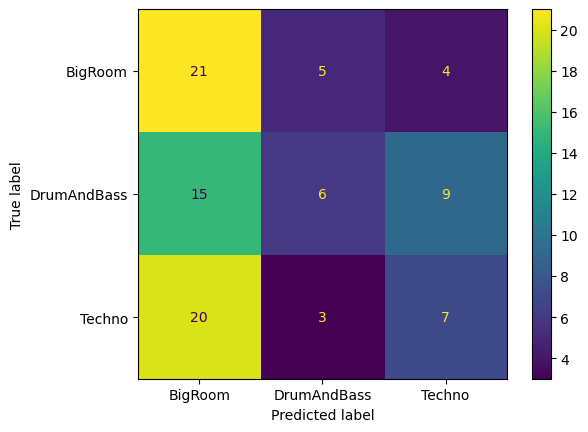

In [32]:
print('The accuracy on the test set is: ' + str(accuracy_score(test_labels, test_predictions3)))

# Create the confusion matrix
confusion_mtx3 = confusion_matrix(test_labels, test_predictions3)

# Plot the confusion matrix
disp3 = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx3, display_labels=['BigRoom', 'DrumAndBass', 'Techno'])

# Plot the confusion matrix
disp3.plot()

# GRID SEARCH

### Defining the model as a function

In [ ]:

def create_model(optimizer='adam', kernel_size=(3,3), activation='relu', batch_size=32):
    model = Sequential([
                Conv2D(32, kernel_size, activation=activation, input_shape=input_shape), 
                MaxPooling2D((2, 2)),
                Conv2D(64, kernel_size, activation=activation),
                MaxPooling2D((2, 2)),
                Flatten(),
                Dense(128, activation=activation),
                Dropout(0.5),
                Dense(3, activation='softmax')
            ])
    model.compile(
               optimizer=optimizer,
               loss='categorical_crossentropy',
               metrics=['accuracy']
            )
    early_stop = EarlyStopping(monitor='val_loss', patience=2)
    history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=train_data_gen.samples // batch_size,
        epochs=100,
        validation_data=validation_data_gen,
        validation_steps=validation_data_gen.samples // batch_size,
        workers=8,
        callbacks=[early_stop]
    )
    return model


In [ ]:
# define the parameters you want to search
optimizers = ['adam', 'sgd']
metrics = ['accuracy', 'precision']
batch_sizes = [32, 64]
kernel_sizes = [(2,2), (3,3), (4,4)]
activations = ['relu', 'tanh']

param_grid = dict(optimizer=optimizers, kernel_size=kernel_sizes, activation=activations, batch_size=batch_sizes)

# create a KerasClassifier from your model function
model = KerasClassifier(build_fn=create_model, epochs=100, validation_data=validation_data_gen, verbose=0)

# create the GridSearchCV object and fit it to your data
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data_gen)

# print the best parameters and score
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

# Plotting Loss and Other Metrics

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [ ]:
### KFOLD CROSS VALIDATION RECOMMENDED BY CHATGPT

from sklearn.model_selection import KFold

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f"Fold {fold+1}")
    train_data = X_train[train_idx]
    train_labels = y_train[train_idx]
    val_data = X_train[val_idx]
    val_labels = y_train[val_idx]
    
    # Build and train model
    model = ...
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), ...)
